In [1]:
# imports
from __future__ import division
from collections import defaultdict
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

from polara.recommender.models import RecommenderModel
from polara.recommender.data import RecommenderData
from polara.tools.movielens import get_movielens_data
from polara.lib.similarity import combine_similarity_data

from models_sparse import FeatureSimilarityMixin

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
class SimilarityDataModel(FeatureSimilarityMixin, RecommenderData): pass

In [3]:
class ContentBased(RecommenderModel):
    def __init__(self, *args, **kwargs):
        super(ContentBased, self).__init__(*args, **kwargs)
        self.method = 'CB'

    def build(self, *args, **kwargs):
        # use copy to prevent contaminating original data
        self.item_similarity_matrix = self.data.item_similarity.copy()
        self.item_similarity_matrix.setdiag(0) # exclude self-links
        self.item_similarity_matrix.eliminate_zeros()
        
    def slice_recommendations(self, test_data, shape, start, stop, test_users=None):
        test_matrix, slice_data = self.get_test_matrix(test_data, shape, (start, stop))
        # test matrix is in CSR format
        scores = self.item_similarity_matrix.dot(test_matrix.T).T
        return scores, slice_data

# Prepare data

In [4]:
ml_path = "datasets/ml-1m.zip"

In [5]:
data, genres = get_movielens_data(ml_path, get_genres=True, split_genres=False)
genres = genres.assign(movienm=lambda x: x.movienm.str.decode('unicode_escape'))

id_fix = pd.read_csv('datasets/ml1m_sub.csv')

genres.movieid.replace(id_fix.set_index('ml1mid').movieid, inplace=True)

genres = genres.drop_duplicates(subset='movieid').copy()

data.movieid.replace(id_fix.set_index('ml1mid').movieid, inplace=True)
data = data.drop_duplicates().copy()

In [6]:
meta_info = pd.read_csv('datasets/meta_info_ml1m.csv', sep=';', na_filter=False).set_index('movieid')
meta_info.loc[:, meta_info.columns] = meta_info.loc[:, meta_info.columns].applymap(lambda x: x.split(',') if x else [])

In [7]:
ml_data = data.query('rating>=4').assign(rating=1)

In [8]:
data_stats = ml_data.apply(pd.Series.nunique, axis=0)
data_stats

userid     6038
movieid    3532
rating        1
dtype: int64

In [9]:
ml_data.shape[0] / np.prod(data_stats[['userid', 'movieid']])

0.02697524961765369

In [10]:
ml_data.userid.value_counts().mean()

95.27658164955284

In [11]:
ml_data.userid.value_counts().median()

58.0

# Feature Selection

In [12]:
def plot_categorical(data, x, y, c=None, figsize=(3.7, 2.2)):
    markers = [
    'o', # circle
    'v', # triangle down
    's', # square
    'D', # diamond
    ]
    
    plt.figure(figsize=figsize)
    
    x_map = defaultdict(lambda: len(x_map))
    x_ = data[x].map(x_map.__getitem__)

    if c is not None:
        c_map = defaultdict(lambda: len(c_map))
        c_ = data[c].map(c_map.__getitem__)
        for label, value in c_map.iteritems():
            sel = c_== value
            plt.scatter(x_[sel], data.loc[sel, y], marker=markers[value], label=label)
    else:
        plt.scatter(x_, data[y])
        
    plt.xticks(*reversed(zip(*x_map.iteritems())))
    plt.tight_layout()
    plt.legend(loc='best')

## Single

In [13]:
jw = 'jaccard-weighted'
jd = 'jaccard'
cs = 'cosine'
tc = 'tfidf-cosine'

features = ['director', 'writer', 'cast', 'genres']
sim_types = [jd, jw, cs, tc]

In [14]:
feat_sel_res = {}
folds = [1, 2, 3, 4, 5]

for feature in tqdm_notebook(features, desc='feat'):
    for stype in tqdm_notebook(sim_types, desc='sim', leave=False):
        item_similarity = combine_similarity_data(meta_info[[feature]], similarity_type=stype)
        similarities = {'userid': None, 'movieid': item_similarity}
        sim_indices = {'userid': None, 'movieid': meta_info.index}
        
        data_model = SimilarityDataModel(similarities, sim_indices, ml_data, 'userid', 'movieid', 'rating', seed=0)
        data_model.random_holdout = True
        data_model.holdout_size = 1
        data_model.verbose = False
        
        cb = ContentBased(data_model)
        
        for fold in folds:
            data_model.test_fold = fold
            data_model.prepare()
            cb.build()

            key = '{}--{}'.format(feature, stype)
            nusers = data_model.test.evalset[data_model.fields.userid].nunique()
            feat_sel_res.setdefault(key, []).append(cb.evaluate().true_positive / nusers)

HBox(children=(IntProgress(value=0, description=u'feat', max=4), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'sim', max=4), HTML(value=u'')))

/home/evfro/.local/lib/python2.7/site-packages/polara/recommender/models.py:380: FutureWarning: pandas.lib.fast_zip is deprecated and will be removed in a future version.
  recs_idx = pd.lib.fast_zip(list(recs.nonzero())) #larger


HBox(children=(IntProgress(value=0, description=u'sim', max=4), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'sim', max=4), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'sim', max=4), HTML(value=u'')))

In [15]:
feature_scores = pd.DataFrame(pd.Series(feat_sel_res)
                              .reset_index()
                              .rename(columns={'index':'feature', 0:'score'})
                              .assign(feature = lambda x: x.feature.str.split('--'))
                              .assign(score = lambda x: x.score.apply(np.mean))
                             )
feature_scores = pd.concat([feature_scores.drop('feature', axis=1),
                            pd.DataFrame(feature_scores.feature.tolist(),
                                         columns=['feature', 'metric'])], axis=1)
feature_scores

,score,feature,metric
0,0.036108,cast,cosine
1,0.021698,cast,jaccard
2,0.038759,cast,jaccard-weighted
3,0.037268,cast,tfidf-cosine
4,0.022197,director,cosine
5,0.022197,director,jaccard
6,0.022031,director,jaccard-weighted
7,0.024019,director,tfidf-cosine
8,0.011098,genres,cosine
9,0.004970,genres,jaccard


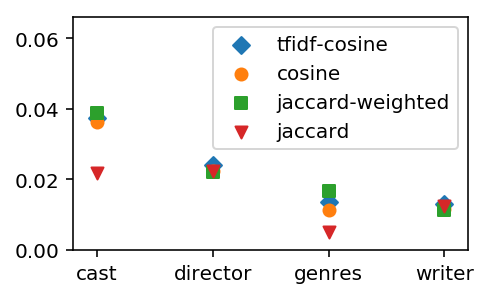

In [16]:
plot_categorical(feature_scores, 'feature', 'score', 'metric')
plt.ylim(0, 0.066);

In [17]:
feature_scores.to_csv('datasets/feature_scores_ML.csv', index=None)

## Combination

In [18]:
feat_combi = [{'cast':jw, 'director':jw}, {'cast':jw, 'genres':tc}, {'cast':jw, 'director':jw, 'genres':tc}]

In [19]:
combi_key = lambda f, s: '{}-{}'.format(f[0], ''.join([x[0] for x in s.split('-')]))
[combi_key(f, s) for f, s in feat_combi[0].iteritems()]

['d-jw', 'c-jw']

In [20]:
feat_sel_res_combi = {}
folds = [1, 2, 3, 4, 5]
for stype in tqdm_notebook(feat_combi, desc='combi', leave=False):
    item_similarity = combine_similarity_data(meta_info[stype.keys()], similarity_type=stype)
    similarities = {'userid': None, 'movieid': item_similarity}

    data_model = SimilarityDataModel(similarities, sim_indices, ml_data, 'userid', 'movieid', 'rating', seed=0)
    data_model.random_holdout = True
    data_model.holdout_size = 1
    data_model.verbose = False
    
    cb = ContentBased(data_model)

    for fold in tqdm_notebook(folds, desc='fold', leave=False):
        data_model.test_fold = fold
        data_model.prepare()
        cb.build()

        key = '_'.join(combi_key(f, s) for f, s in stype.iteritems())
        nusers = data_model.test.evalset[data_model.fields.userid].nunique()
        feat_sel_res_combi.setdefault(key, []).append(cb.evaluate().true_positive / nusers)

HBox(children=(IntProgress(value=0, description=u'combi', max=3), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'fold', max=5), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'fold', max=5), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'fold', max=5), HTML(value=u'')))

In [21]:
feature_scores = pd.DataFrame(pd.Series(feat_sel_res_combi)
                              .reset_index()
                              .rename(columns={'index':'feature', 0:'score'})
                              .assign(feature = lambda x: x.feature.str.split('--'))
                              .assign(score = lambda x: x.score.apply(np.mean))
                             )
feature_scores

,feature,score
0,[c-jw_g-tc],0.026338
1,[d-jw_c-jw],0.033957
2,[d-jw_c-jw_g-tc],0.031474
